# CS413 Image and Video Analysis -- Lab 8 a

## Department of Computer Science, University of Warwick
## Term-1 (2024-25)


## Aims:

The aims of this lab are to

+ Use Keras to build a multi-layer perceptron (MLP) to classify object classes
+ Evaulate how good the classifier is using confusion matrices and compare with SVM model from last week

## Multi-Layer Perceptrons using Keras

In the following, you will investigate whether you can use perform a better
predictor than the SVM from last week using an Artificial Neural Network (ANN).

In particular, we will start by building Multi-Layer Perceptron (MLP).

The MLP will be designed to input BOW features and output a label class (between 0-99).
So the input dimensionality will be `dictonarySize` and the output dimensionality will
be 100.

Here are the main steps of the method:
    
    1. Declare which Keras libraries we need: which ANN layers, optimizer etc.
    2. Wrangle the data into appropriate normalised input and output arrays {X, y} pairs
    3. Split the data into a training and a validation set
    4. Specify the ANN architecture (build the network and compile it)
    5. Train the network
    
Then we will do as above, which is to evaluate how good the predictor is.

In [7]:
# make some library declarations
import tensorflow as tf

# get keras classes which are now in tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop

# check we have the lastest versions
print('tensorflow version', tf.__version__)
print('keras version', tf.keras.__version__)

tensorflow version 2.17.0
keras version 3.5.0


### Wrangle the data

We need to make sure that the input range is [0, 1] (which it is for BOW features).

The labels `y` need to be in the range [0,99] so we subtract 1 from `classes`.

We can use the `sklearn.utils.shuffle` to randomize the order of the data and the
corresponding lables.

Finally, we can split the data into a `train` and a `validate` set. We need to do this
for both the `x` and `y` vectors.

In [8]:
import glob
import cv2  # OpenCV
import numpy as np
from sklearn.utils import shuffle

num_classes = 10

data_dir = '/modules/cs413/data/coil-100/'

images = []
classes = []
example_images = []
do_limit = False
max_per_class = 32
for i in range(num_classes):

    filenames = glob.glob(data_dir + 'obj' + str(i+1) + '_*.png')

    for j in range(len(filenames)):

        im_gbr = cv2.imread(filenames[j])
        im = cv2.cvtColor(im_gbr, cv2.COLOR_BGR2RGB)  

        images.append(im)
        classes.append(i + 1)

        if j == 0:
            example_images.append(im)  

        if do_limit:
            if j >= max_per_class:
                break

print('read ', len(images), ' images ')

num_data = len(images)

img_height, img_width, num_channels = images[0].shape
dictionarySize = img_height * img_width * num_channels  

x = np.array(images).reshape(num_data, dictionarySize).astype('float32')
y = np.array(classes) - 1  

num_classes = np.max(y) + 1

print('x shape is ', x.shape)
print('y shape is ', y.shape)
print('num classes is ', num_classes)

x, y = shuffle(x, y)


num_train = int(0.7 * num_data)
num_validate = num_data - num_train

x_train, y_train = x[:num_train], y[:num_train]
x_validate, y_validate = x[num_train:], y[num_train:]

x_train = (x_train - np.min(x)) / (np.max(x) - np.min(x))  
x_validate = (x_validate - np.min(x)) / (np.max(x) - np.min(x)) 

print(x_train.shape[0], 'train samples')
print(x_validate.shape[0], 'validation samples')


read  720  images 
x shape is  (720, 49152)
y shape is  (720,)
num classes is  10
503 train samples
217 validation samples


### One-Hot-Coding

The ANN will produce a vector probabilities (of length 100), where a 1.0 in
position `c` indicates that class `c` has been predicted.

To train the network, we need to use *one-hot-coding* of our labels `y` before
we can use them to train the network.  This is done by
```
    y_one_hot = tf.keras.utils.to_categorical(y, num_classes)
    
```

In [9]:
# convert class vectors to binary class matrices


y_train_ohc = tf.keras.utils.to_categorical(y_train, num_classes)
y_validate_ohc = tf.keras.utils.to_categorical(y_validate, num_classes)

print('Num clases is ', num_classes)

print('Example of one-hot-coding: ')
print(y_train_ohc[0])
print(' is class ', y[0])

Num clases is  10
Example of one-hot-coding: 
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 is class  6


## Exercise 1

1. Build a MLP with 1 hidden layer (start with 32 neurons)

2. Train your network

3. If the network is overfitting, you may want to some things:
    
    1. change the number of neurons in the hidden layer
    2. try a `Dropout` layer after the hidden layer, e.g. with a dropout rate of 25%
    ~~~~
        mode.add(Dropout(0.25))
    ~~~~
    3. change the batch size
    4. try a smaller learning rate in the optimizer (change the `lr` value)
    
4. If it is not overfitting, can you get it to be more accurate by increasing the number of epochs?

5. Can you get more accuracy by adding a second hidden layer? Does it start to overfit or still work as well?

In [10]:
# Define input shape based on the dictionary size
input_shape = (dictionarySize,)  # Input layer

# Build the MLP model
model = Sequential()

# Add the first hidden layer with 32 neurons
model.add(Dense(32, activation='relu', input_shape=input_shape))

# Optionally add a Dropout layer to prevent overfitting
model.add(Dropout(0.25))  # 25% dropout

# Add the output layer
model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax activation

# Display model architecture
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 32)             │     1,572,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,573,226 (6.00 MB)

 Trainable params: 1,573,226 (6.00 MB)

 Non-trainable params: 0 (0.00 B)

## Training and fitting

This is how we would compile and fit the model

Note that each time we call `compile()` the weights get re-initialised.


In [11]:
# Compile the model
epochs = 100  # You can try 100, 300, 500
batch_size = 32  # You can try 32, 64, 128
learning_rate = 0.001  # Default value, you can reduce it if necessary

optimizer = Adam(learning_rate=learning_rate)  # Adam optimizer with specified learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train_ohc,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_validate, y_validate_ohc))


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1586 - loss: 5.9035 - val_accuracy: 0.2673 - val_loss: 2.1836
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2423 - loss: 2.1232 - val_accuracy: 0.2995 - val_loss: 2.0022
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2626 - loss: 1.9962 - val_accuracy: 0.2581 - val_loss: 1.9594
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2808 - loss: 1.9498 - val_accuracy: 0.2535 - val_loss: 1.8964
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2570 - loss: 1.9073 - val_accuracy: 0.2535 - val_loss: 1.8669
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2545 - loss: 1.9089 - val_accuracy: 0.2535 - val_loss: 1.8374
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2668 - loss: 1.8646 - val_accuracy: 0.2535 - val_loss: 1.8102
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2936 - loss: 1.8356 - val_accuracy: 0.

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4248 - loss: 1.5482 - val_accuracy: 0.4885 - val_loss: 1.4068
Epoch 52/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3790 - loss: 1.6039 - val_accuracy: 0.4885 - val_loss: 1.3985
Epoch 53/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4187 - loss: 1.5476 - val_accuracy: 0.4977 - val_loss: 1.4002
Epoch 54/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4388 - loss: 1.5522 - val_accuracy: 0.4654 - val_loss: 1.3929
Epoch 55/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4338 - loss: 1.5102 - val_accuracy: 0.4977 - val_loss: 1.3936
Epoch 56/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4361 - loss: 1.5799 - val_accuracy: 0.4839 - val_loss: 1.3884
Epoch 57/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4001 - loss: 1.5954 - val_accuracy: 0.4839 - val_loss: 1.3839
Epoch 58/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4390 - loss: 1.5338 - val_accuracy: 0.4977 

## Plotting Training and Validation Accuracy

The `history` return from `fit()` will store the statistics from each epcho and we can
plot these to see whether the validation loss is lower than the training loss (which we want),
or whether the model is starting to over fit.

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


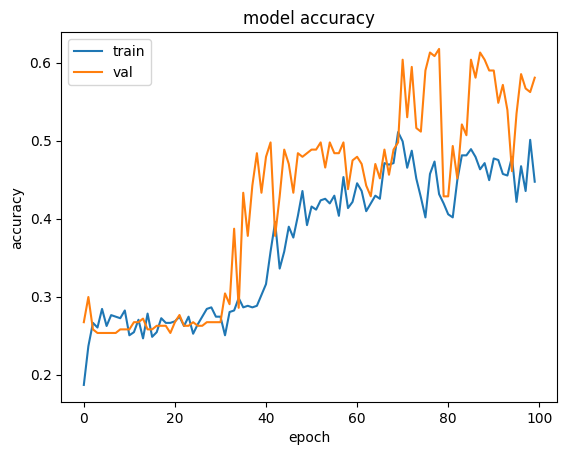

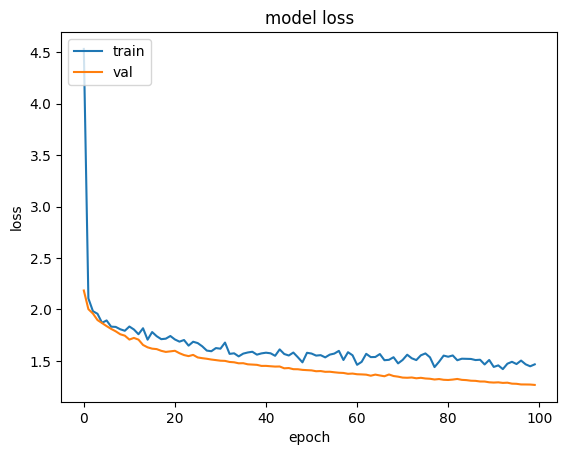

In [13]:
# this plots the change of accuracy and loss over time (stored in the 'history')
import matplotlib.pyplot as plt

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Evaluating the trained model

We can see from the validation accuracy on the last epoch how good the model will be.

The `evaluate()` function can give us a score (the loss and the accuracy) like this...

In [14]:
score = model.evaluate(x_validate, y_validate_ohc, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.265384316444397
Test accuracy: 0.5806451439857483


## Exercise 2

1. Calculate a second confusion matrix for this model and compare it with the SVM from last week

2. Split your input data into three parts: training, validation and test. Do not use the
    test data for training but to measure the score of a newly trained model.
    
3. Build and train a second MLP with multiple hidden layers and try to optimize the architecture of the network.
What is the best accuracy you can achieve with this new MLP?


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Confusion Matrix:
 [[26  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0 19  0  6  0  0  0]
 [ 0  0  6  0  0  9  0  0  0  0]
 [ 0  0  0 17  0  0  0  0  0  0]
 [ 0  0  0  0 19  0  0  0  0  0]
 [ 2  0  0  0  2 12  0  0  0  0]
 [ 0  0  0  0  0  0 26  0  0  0]
 [ 0  0  0  0 26  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 19  0]
 [ 0  0  0  0 27  0  0  0  0  0]]


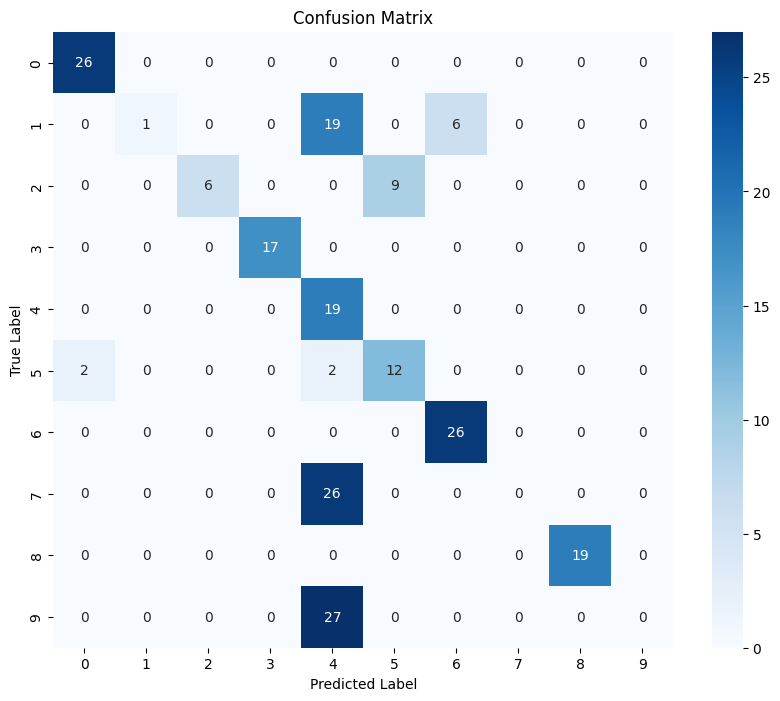

In [15]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(x_validate)  
y_pred_classes = np.argmax(y_pred, axis=1)  
y_true = np.argmax(y_validate_ohc, axis=1)  
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", cm)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [19]:
from tensorflow.keras.utils import to_categorical

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
x_validate, x_test, y_validate, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print("Training set size:", x_train.shape[0])
print("Validation set size:", x_validate.shape[0])
print("Test set size:", x_test.shape[0])

y_train_ohc = to_categorical(y_train, num_classes=num_classes)
y_validate_ohc = to_categorical(y_validate, num_classes=num_classes)
y_test_ohc = to_categorical(y_test, num_classes=num_classes)

print("y_train_ohc shape:", y_train_ohc.shape)
print("y_validate_ohc shape:", y_validate_ohc.shape)
print("y_test_ohc shape:", y_test_ohc.shape)

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=input_shape)) 
model.add(Dropout(0.3)) 
model.add(Dense(64, activation='relu')) 
model.add(Dense(num_classes, activation='softmax')) 

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train_ohc,
                    batch_size=64,
                    epochs=300,
                    validation_data=(x_validate, y_validate_ohc))

score = model.evaluate(x_test, y_test_ohc, verbose=0)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Training set size: 504
Validation set size: 108
Test set size: 108
y_train_ohc shape: (504, 10)
y_validate_ohc shape: (108, 10)
y_test_ohc shape: (108, 10)
Epoch 1/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.1504 - loss: 803.4725 - val_accuracy: 0.5000 - val_loss: 312.7138
Epoch 2/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3311 - loss: 442.5010 - val_accuracy: 0.4352 - val_loss: 64.5957
Epoch 3/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4881 - loss: 118.2145 - val_accuracy: 0.7870 - val_loss: 18.6192
Epoch 4/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5691 - loss: 46.5743 - val_accuracy: 0.7963 - val_loss: 12.3050
Epoch 5/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4910 - loss: 28.0421 - val_accuracy: 0.6204 - val_loss: 3.5809
Epoch 6/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4500 - loss: 9.5867 - val_accuracy: 0.4074 - val_loss: 1.9289
Epoch 7/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3555 - loss

Epoch 51/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5296 - loss: 1.1629 - val_accuracy: 0.6389 - val_loss: 0.9549
Epoch 52/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5022 - loss: 1.2828 - val_accuracy: 0.6852 - val_loss: 0.9824
Epoch 53/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5294 - loss: 1.2210 - val_accuracy: 0.6111 - val_loss: 1.0255
Epoch 54/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5232 - loss: 1.2212 - val_accuracy: 0.6389 - val_loss: 0.9664
Epoch 55/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5220 - loss: 1.1325 - val_accuracy: 0.6481 - val_loss: 0.9823
Epoch 56/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5035 - loss: 1.2946 - val_accuracy: 0.6481 - val_loss: 0.9798
Epoch 57/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5292 - loss: 1.2063 - val_accuracy: 0.6481 - val_loss: 0.9592
Epoch 58/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5460 - loss: 1.1356 - val_accuracy: 0.6389 - v

Epoch 102/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5459 - loss: 1.1398 - val_accuracy: 0.6852 - val_loss: 0.9451
Epoch 103/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5268 - loss: 1.2259 - val_accuracy: 0.6759 - val_loss: 0.9032
Epoch 104/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5406 - loss: 1.2091 - val_accuracy: 0.6852 - val_loss: 0.9036
Epoch 105/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5212 - loss: 1.3020 - val_accuracy: 0.5833 - val_loss: 1.0862
Epoch 106/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5421 - loss: 1.2092 - val_accuracy: 0.6204 - val_loss: 1.0334
Epoch 107/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5246 - loss: 1.2423 - val_accuracy: 0.6296 - val_loss: 0.9833
Epoch 108/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5013 - loss: 1.2940 - val_accuracy: 0.6019 - val_loss: 1.0558
Epoch 109/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4780 - loss: 1.3250 - val_accuracy: 0.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5790 - loss: 1.1289 - val_accuracy: 0.6481 - val_loss: 0.8793
Epoch 153/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6181 - loss: 1.0036 - val_accuracy: 0.6481 - val_loss: 0.8818
Epoch 154/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5918 - loss: 1.1001 - val_accuracy: 0.6481 - val_loss: 0.8958
Epoch 155/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5625 - loss: 1.1779 - val_accuracy: 0.6574 - val_loss: 0.8706
Epoch 156/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5836 - loss: 1.0777 - val_accuracy: 0.6574 - val_loss: 0.8778
Epoch 157/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6003 - loss: 1.0991 - val_accuracy: 0.6481 - val_loss: 0.8766
Epoch 158/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5898 - loss: 1.0859 - val_accuracy: 0.6481 - val_loss: 0.8769
Epoch 159/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5928 - loss: 1.0758 - val_accuracy: 0.6574 - val_los

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5576 - loss: 1.1105 - val_accuracy: 0.6481 - val_loss: 0.8332
Epoch 203/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5902 - loss: 1.1137 - val_accuracy: 0.6667 - val_loss: 0.8247
Epoch 204/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5714 - loss: 1.1473 - val_accuracy: 0.6667 - val_loss: 0.8339
Epoch 205/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6025 - loss: 1.0571 - val_accuracy: 0.6667 - val_loss: 0.8357
Epoch 206/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5884 - loss: 1.0424 - val_accuracy: 0.6667 - val_loss: 0.8323
Epoch 207/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6135 - loss: 1.0184 - val_accuracy: 0.6667 - val_loss: 0.8313
Epoch 208/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5878 - loss: 1.0785 - val_accuracy: 0.6667 - val_loss: 0.8489
Epoch 209/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5708 - loss: 1.1179 - val_accuracy: 0.6852 - val_los

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5476 - loss: 1.1572 - val_accuracy: 0.6481 - val_loss: 0.8479
Epoch 253/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5316 - loss: 1.1941 - val_accuracy: 0.6204 - val_loss: 0.8937
Epoch 254/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5910 - loss: 1.0380 - val_accuracy: 0.6759 - val_loss: 0.7942
Epoch 255/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5220 - loss: 1.1909 - val_accuracy: 0.6481 - val_loss: 0.7964
Epoch 256/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5679 - loss: 1.1298 - val_accuracy: 0.5926 - val_loss: 0.9546
Epoch 257/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5297 - loss: 1.1678 - val_accuracy: 0.5556 - val_loss: 1.0903
Epoch 258/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5096 - loss: 1.2362 - val_accuracy: 0.5741 - val_loss: 0.9806
Epoch 259/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5206 - loss: 1.2628 - val_accuracy: 0.6574 - val_los